In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    cohen_kappa_score
)
from scipy.stats import entropy
from tqdm.auto import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
import os

df = pd.read_csv('df_text_clas.csv', encoding='utf-8', nrows=100)
df.replace(['No information', 'No relevant information found', np.nan], '', inplace=True)

In [2]:
labelling_map = {
    'vic_grupo_social': 'vic_grupo_social_classification',
    'amenaza_quien': 'amenaza_quien_classification',
    'captura_metodo': 'captura_metodo_classification',
    'captura_tipo': 'captura_tipo_classification',
    'cautiverio_trato': 'cautiverio_trato_classification',
    'desenlace': 'desenlace_classification',
    'desenlace_tipo': 'desenlace_tipo_classification',
    'perp_tipo1': 'perp_tipo1_classification',
    'perp_tipo2': 'perp_tipo2_classification',
    'proced_contacto1': 'proced_contacto1_classification',
    'proced_contacto2': 'proced_contacto2_classification',
    'proced_contactado': 'proced_contactado_classification',
    'Tribunal_tipo': 'Tribunal_tipo_classification',
    'proced_sent_tipo': 'proced_sent_tipo_classification',
    'soc_civil': 'soc_civil_classification'
}
labelling_map = dict(list(labelling_map.items())[:10])

# victim level
df['victim_id'] = df['index'].str.rsplit('_', n=1).str[0]
columns_to_aggregate = list(labelling_map.keys()) + list(labelling_map.values())
df_victim_consensus = df.groupby('victim_id')[columns_to_aggregate].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

def weight_choice_sig(group):
    """
    Calculates a score for each category based on:
    Score = Frequency * Average_Sigmoid_Weight
    The sigmoid weight is derived from standardized 'text_words'.
    """
    output = {}
    
    # Standardize 'text_words' to center the data for the sigmoid function
    mean_words, std_words = group['text_words'].mean(), group['text_words'].std()
    
    if std_words > 0:
        standardized_words = (group['text_words'] - mean_words) / std_words
    else:
        standardized_words = pd.Series(0.0, index=group.index)
        
    group['final_weight'] = 1 / (1 + np.exp(-standardized_words))

    for col in columns_to_aggregate:
        # Skip columns that are all empty/null
        if group[col].astype(str).str.strip().eq('').all():
            output[col] = None
            continue

        freq = group[col].value_counts()
        avg_weight = group.groupby(col)['final_weight'].mean()
        final_score = freq * avg_weight
        
        if not final_score.empty:
            output[col] = final_score.idxmax()
        else:
            output[col] = None
            
    return pd.Series(output)

def weight_choice_log(group):
    """
    Calculates a score for each category based on:
    Score = Frequency * Average_Log_Scaled_Weight
    The weight is derived from log-transformed and min-max scaled 'text_words'.
    """
    output = {}
    
    # Apply Log Transform, then Min-Max Scale the result
    group['log_words'] = np.log1p(group['text_words'])
    min_log, max_log = group['log_words'].min(), group['log_words'].max()
    
    if (max_log - min_log) > 0:
        group['final_weight'] = (group['log_words'] - min_log) / (max_log - min_log)
    else:
        group['final_weight'] = 1.0

    for col in columns_to_aggregate:
        # Skip columns that are all empty/null
        if group[col].astype(str).str.strip().eq('').all():
            output[col] = None
            continue

        freq = group[col].value_counts()
        avg_weight = group.groupby(col)['final_weight'].mean()
        final_score = freq * avg_weight
        
        if not final_score.empty:
            output[col] = final_score.idxmax()
        else:
            output[col] = None
            
    return pd.Series(output)


df_victim_sig = df.groupby('victim_id').apply(weight_choice_sig, include_groups=False).reset_index()
df_victim_log = df.groupby('victim_id').apply(weight_choice_log, include_groups=False).reset_index()

df_victim_consensus.to_csv('df_clas_by_victim_consensus.csv', index=False)
df_victim_sig.to_csv('df_clas_by_victim_sig.csv', index=False)
df_victim_log.to_csv('df_clas_by_victim_log.csv', index=False)


In [3]:
def calculate_metrics(annotation, classification):
    '''confusion matrix including acc, sensitivity, specificity, precision, f1, kappa'''
    annotation = annotation.fillna('')
    classification = classification.fillna('')
    labels = np.unique(np.concatenate((annotation, classification)))
    cm = confusion_matrix(annotation, classification, labels=labels)
    
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        specificity_per_class = TN / (TN + FP)
        specificity_per_class[np.isnan(specificity_per_class)] = 0
    
    specificity_macro = np.mean(specificity_per_class)

    metrics = {
        'confusion_matrix': cm,
        'accuracy': accuracy_score(annotation, classification),
        'precision_macro': precision_score(annotation, classification, average='macro', zero_division=0),
        'sensitivity_macro': recall_score(annotation, classification, average='macro', zero_division=0),
        'specificity_macro': specificity_macro,
        'f1_macro': f1_score(annotation, classification, average='macro', zero_division=0),
        'cohen_kappa': cohen_kappa_score(annotation, classification, labels=labels)
    }
    return metrics

def calculate_extrinsic_hallucination_rate(annotation, classification):
    '''the machine is making unverifiable claim in the text (machine false relevant), out of all the assertions machine made (all machine relevant, false positive + true positive) (1-precision)'''
    annotation_binary = annotation.fillna('').astype(str).ne('').astype(int)
    classification_binary = classification.fillna('').astype(str).ne('').astype(int)
    precision = precision_score(annotation_binary, classification_binary, pos_label=1, average='binary', zero_division=0)
    return 1 - precision

def calculate_intrinsic_hallucination_rate(annotation, classification):
    '''the machine generated claims that contradicts the human classification (accuracy) out of the cases when both human and machine find it relevant (given both relevant)'''
    relevant_mask = (annotation.fillna('') != '') & (classification.fillna('') != '')
    annotation_relevant = annotation[relevant_mask]
    classification_relevant = classification[relevant_mask]

    if len(annotation_relevant) == 0:
        return 0.0

    return accuracy_score(annotation_relevant, classification_relevant)

def calculate_omission_rate(annotation, classification):
    '''when machine did not find something when human found something (false non relevant), out of all relevant cases where it should find them (all human relevant, false negative + true positive) (1-sensitivity)'''
    annotation_binary = annotation.fillna('').astype(str).ne('').astype(int)
    classification_binary = classification.fillna('').astype(str).ne('').astype(int)
    sensitivity = recall_score(annotation_binary, classification_binary, pos_label=1, average='binary', zero_division=0)
    return 1 - sensitivity

def calculate_consistency(df, index_col_name, classification_col_name_name):
    """
    Calculates the consistency of machine classifications for each victim using Shannon entropy.
    A score of 0 indicates perfect consistency (all classifications for a victim are the same).
    A score of 1 indicates perfect inconsistency (classifications are uniformly distributed).
    """
    df_temp = df[[index_col_name, classification_col_name_name]].copy()
    df_temp.dropna(subset=[classification_col_name_name], inplace=True)
    df_temp = df_temp[df_temp[classification_col_name_name] != '']

    if df_temp.empty:
        return pd.Series(dtype=float)

    df_temp['victim_id'] = df_temp[index_col_name].str.rsplit('_', n=1).str[0]

    # n_i is the count of reports for this victim, example: joe has 3 reports, so n_{joe} = 3
    # p_ij is the probability of reports classified as category j for victim i, for example: joe's 3 reports are classified as {a, a, b}, so p_{joe, a} = 2/3 and p_{joe, b} = 1/3
    n_i = df_temp.groupby('victim_id').size()
    counts_ij = df_temp.groupby(['victim_id', classification_col_name_name]).size().unstack(fill_value=0)
    p_ij = counts_ij.values / n_i.values[:, np.newaxis]
    H_i = -np.sum(np.where(p_ij > 0, p_ij * np.log2(p_ij), 0), axis=1)
    H_bar_within = np.mean(H_i)
    H_bar_within_weighted = np.average(H_i, weights=n_i.values)

    # Calculate the overall probability distribution of classifications (p_j)
    p_j = counts_ij.sum(axis=0).values / n_i.sum()
    H_bar_between = -np.sum(np.where(p_j > 0, p_j * np.log2(p_j), 0))

    K = counts_ij.shape[1]  # number of columns = number of unique categories
    H_max = np.log2(K) if K > 1 else 1.0

    consistency_within = 1 - (H_bar_within / H_max)
    consistency_within_weighted = 1 - (H_bar_within_weighted / H_max)
    consistency_between = 1 - (H_bar_between / H_max)

    results = {
        'consistency_within': consistency_within,
        'consistency_within_weighted': consistency_within_weighted,
        'consistency_between': consistency_between
    }

    return results


In [4]:
dfs = {
    'report_level': df,
    'victim_level_consensus': df_victim_consensus,
    'victim_level_sigmoid': df_victim_sig,
    'victim_level_log': df_victim_log
}

results = {df_name: {} for df_name in dfs.keys()}

# 2. Loop through dataframes, columns, and evaluations
with tqdm(total=len(dfs), desc="Evaluating DataFrame", leave=True, position=0) as pbar:
    for df_name, current_df in dfs.items():
        with tqdm(total=len(labelling_map), desc=f"Processing {df_name}", leave=False, position=1) as pbar_inner:
            for annotation_col_name, classification_col_name in labelling_map.items():
                
                # Ensure both columns exist in the dataframe
                if annotation_col_name not in current_df.columns or classification_col_name not in current_df.columns:
                    pbar_inner.update(1)
                    continue

                annotation = current_df[annotation_col_name]
                classification = current_df[classification_col_name]

                # Store results for each evaluation function
                results[df_name][classification_col_name] = {
                    'metrics': calculate_metrics(annotation, classification),
                    'extrinsic_hallucination': calculate_extrinsic_hallucination_rate(annotation, classification),
                    'intrinsic_hallucination': calculate_intrinsic_hallucination_rate(annotation, classification),
                    'omission_rate': calculate_omission_rate(annotation, classification)
                }
                
                # Add consistency calculation, which only runs on the non-aggregated report level data
                if df_name == 'report_level':
                    results[df_name][classification_col_name]['consistency'] = calculate_consistency(current_df, 'index', classification_col_name)
                
                pbar_inner.update(1)
        pbar.update(1)


Evaluating DataFrame:   0%|          | 0/4 [00:00<?, ?it/s]

Processing report_level:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\meier\AppData\Local\Temp\ipykernel_40212\31472687.py:75: RuntimeWarning: divide by zero encountered in log2
  H_i = -np.sum(np.where(p_ij > 0, p_ij * np.log2(p_ij), 0), axis=1)
C:\Users\meier\AppData\Local\Temp\ipykernel_40212\31472687.py:75: RuntimeWarning: invalid value encountered in multiply
  H_i = -np.sum(np.where(p_ij > 0, p_ij * np.log2(p_ij), 0), axis=1)
C:\Users\meier\AppData\Local\Temp\ipykernel_40212\31472687.py:75: RuntimeWarning: divide by zero encountered in log2
  H_i = -np.sum(np.where(p_ij > 0, p_ij * np.log2(p_ij), 0), axis=1)
C:\Users\meier\AppData\Local\Temp\ipykernel_40212\31472687.py:75: RuntimeWarning: invalid value encountered in multiply
  H_i = -np.sum(np.where(p_ij > 0, p_ij * np.log2(p_ij), 0), axis=1)
C:\Users\meier\AppData\Local\Temp\ipykernel_40212\31472687.py:75: RuntimeWarning: divide by zero encountered in log2
  H_i = -np.sum(np.where(p_ij > 0, p_ij * np.log2(p_ij), 0), axis=1)
C:\Users\meier\AppData\Local\Temp\ipykernel_40212\31472687.py:75

Processing victim_level_consensus:   0%|          | 0/10 [00:00<?, ?it/s]

Processing victim_level_sigmoid:   0%|          | 0/10 [00:00<?, ?it/s]

Processing victim_level_log:   0%|          | 0/10 [00:00<?, ?it/s]

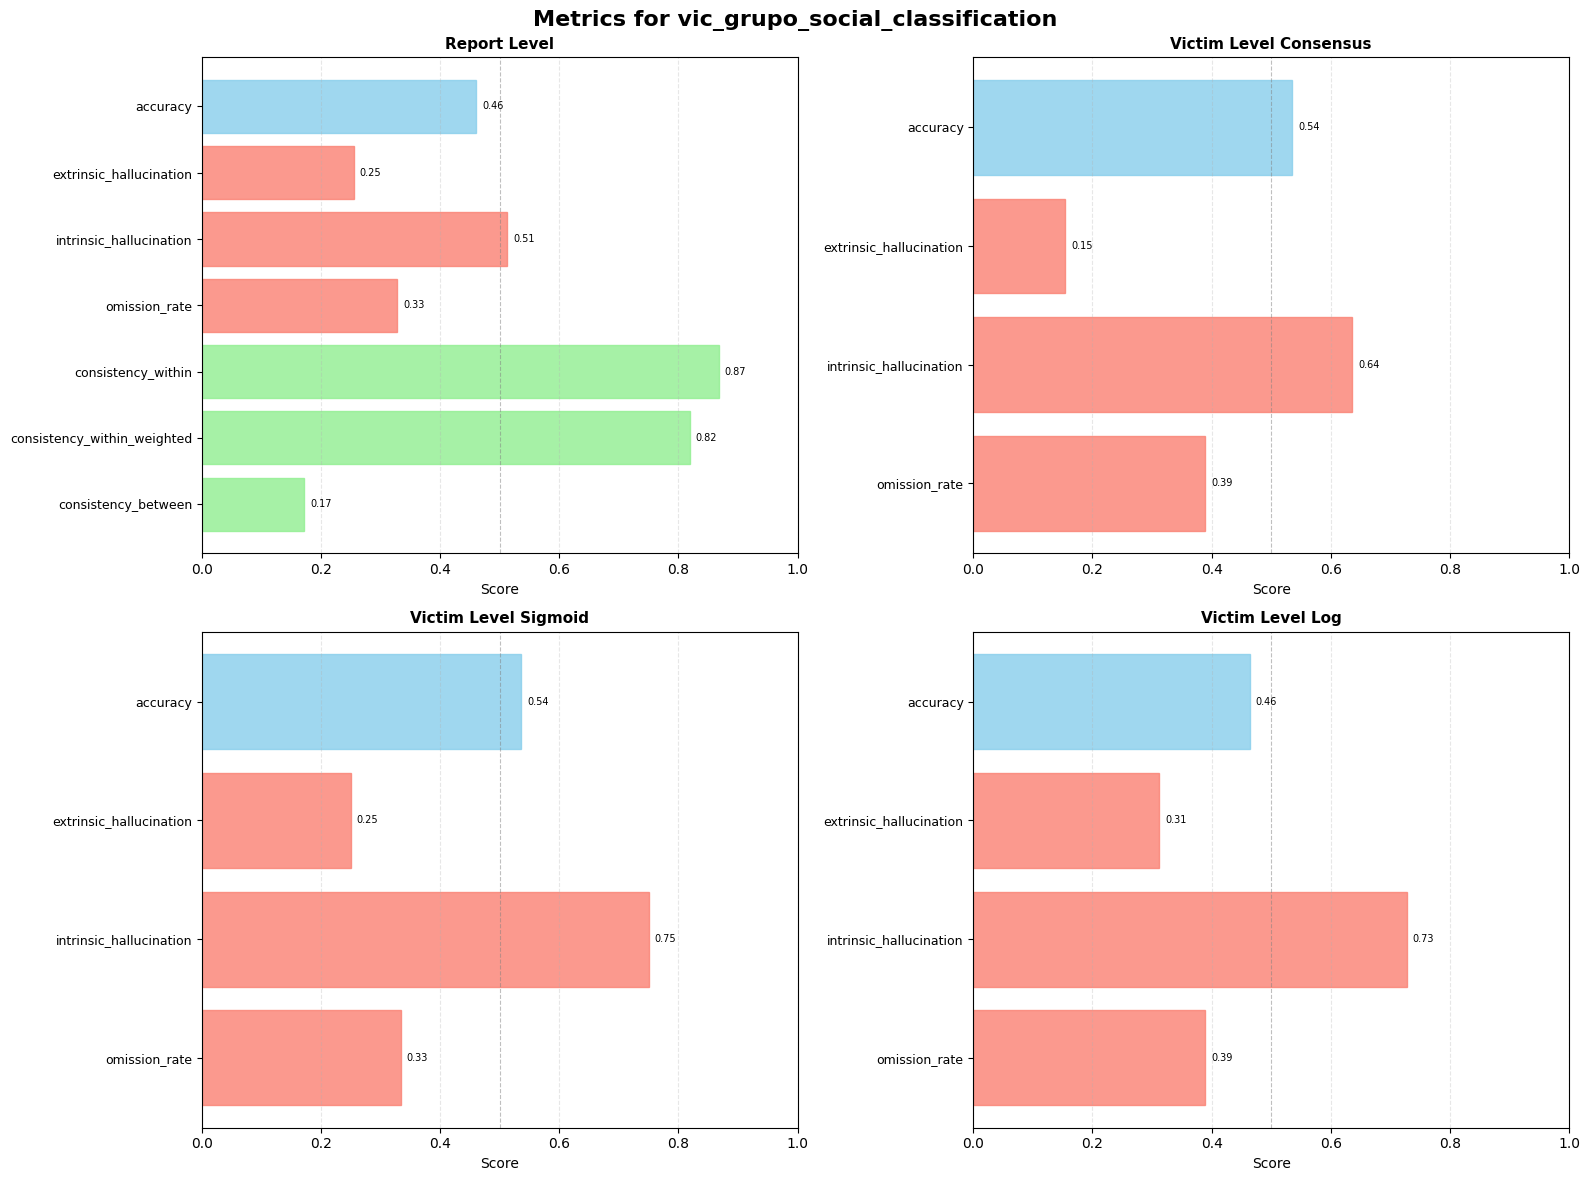

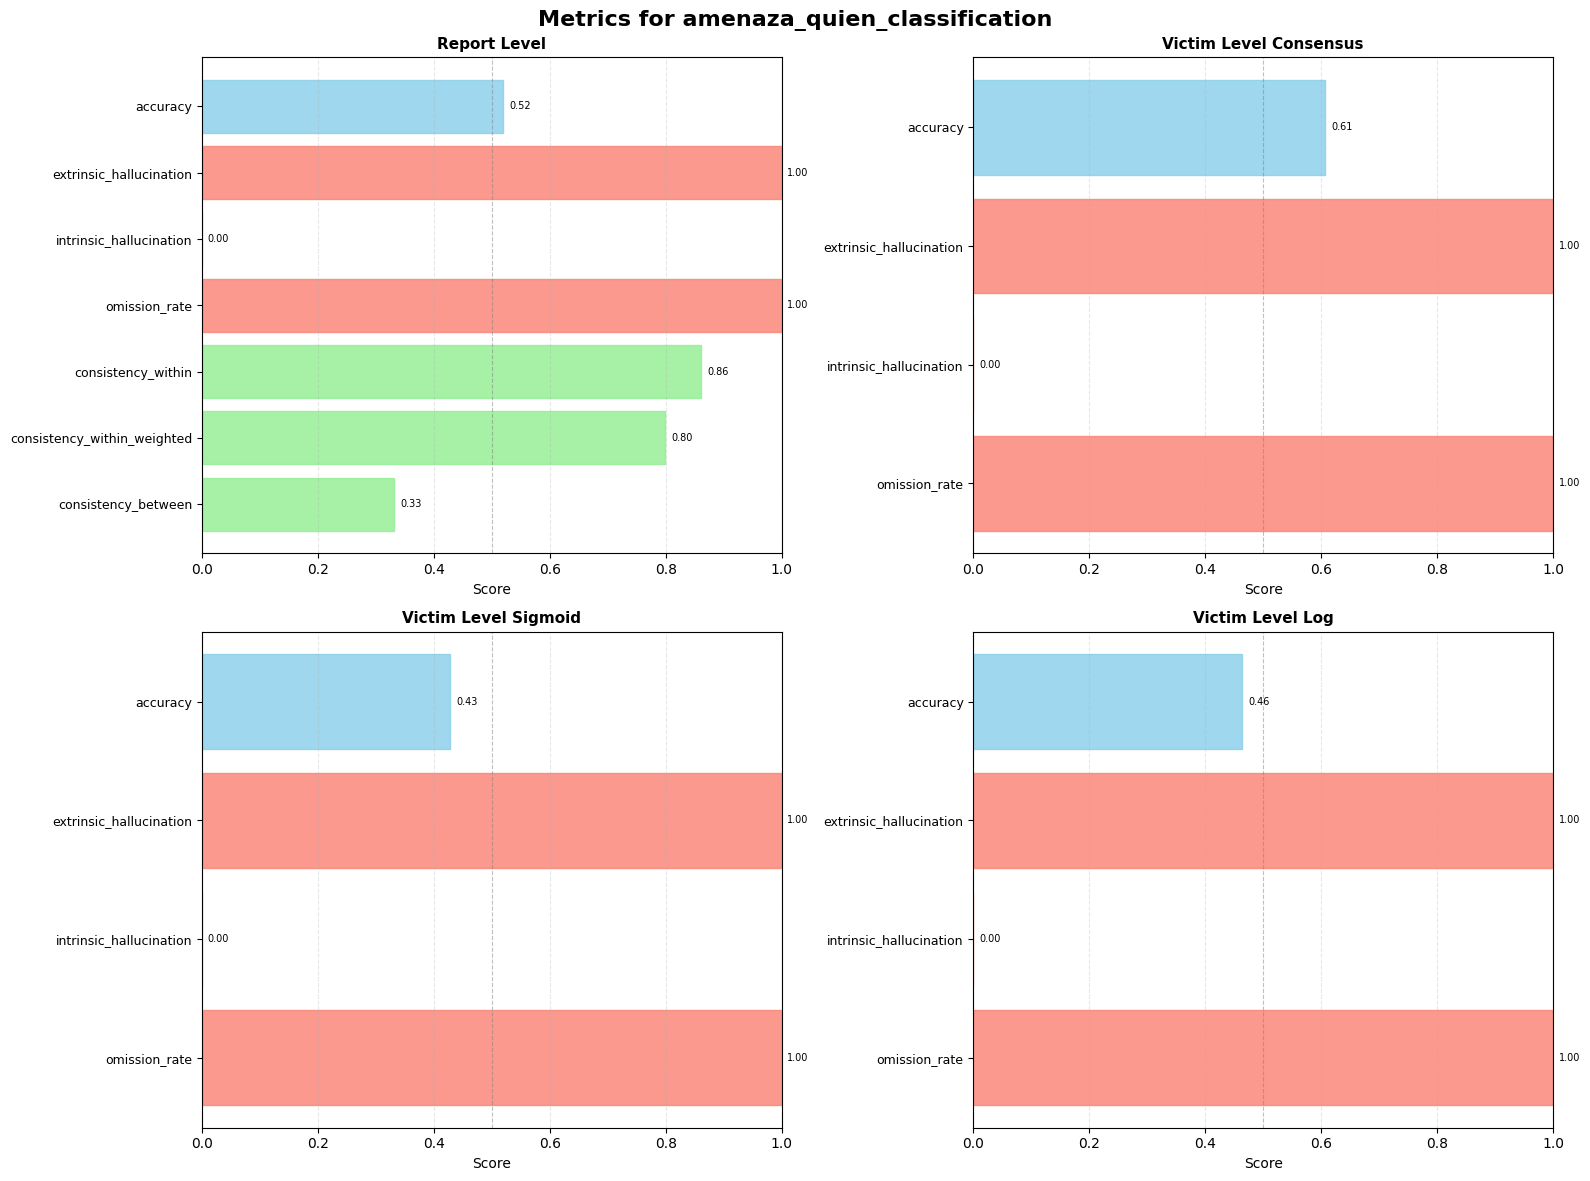

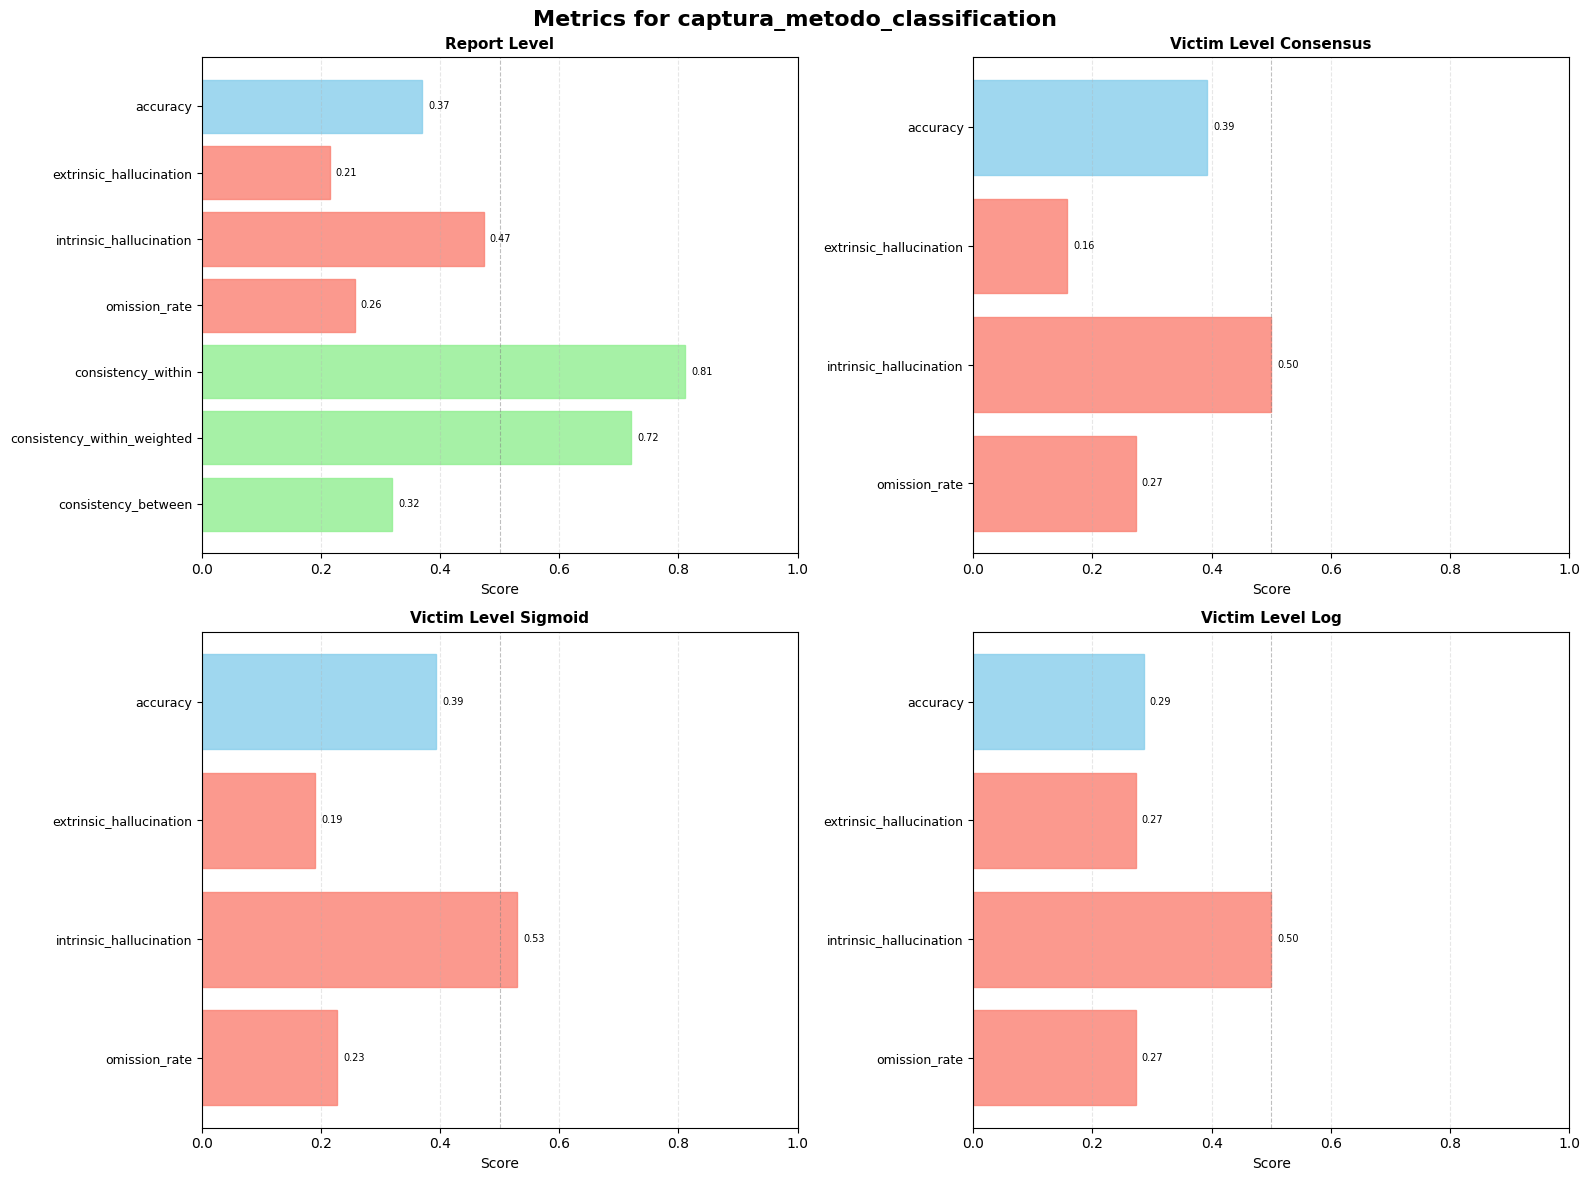

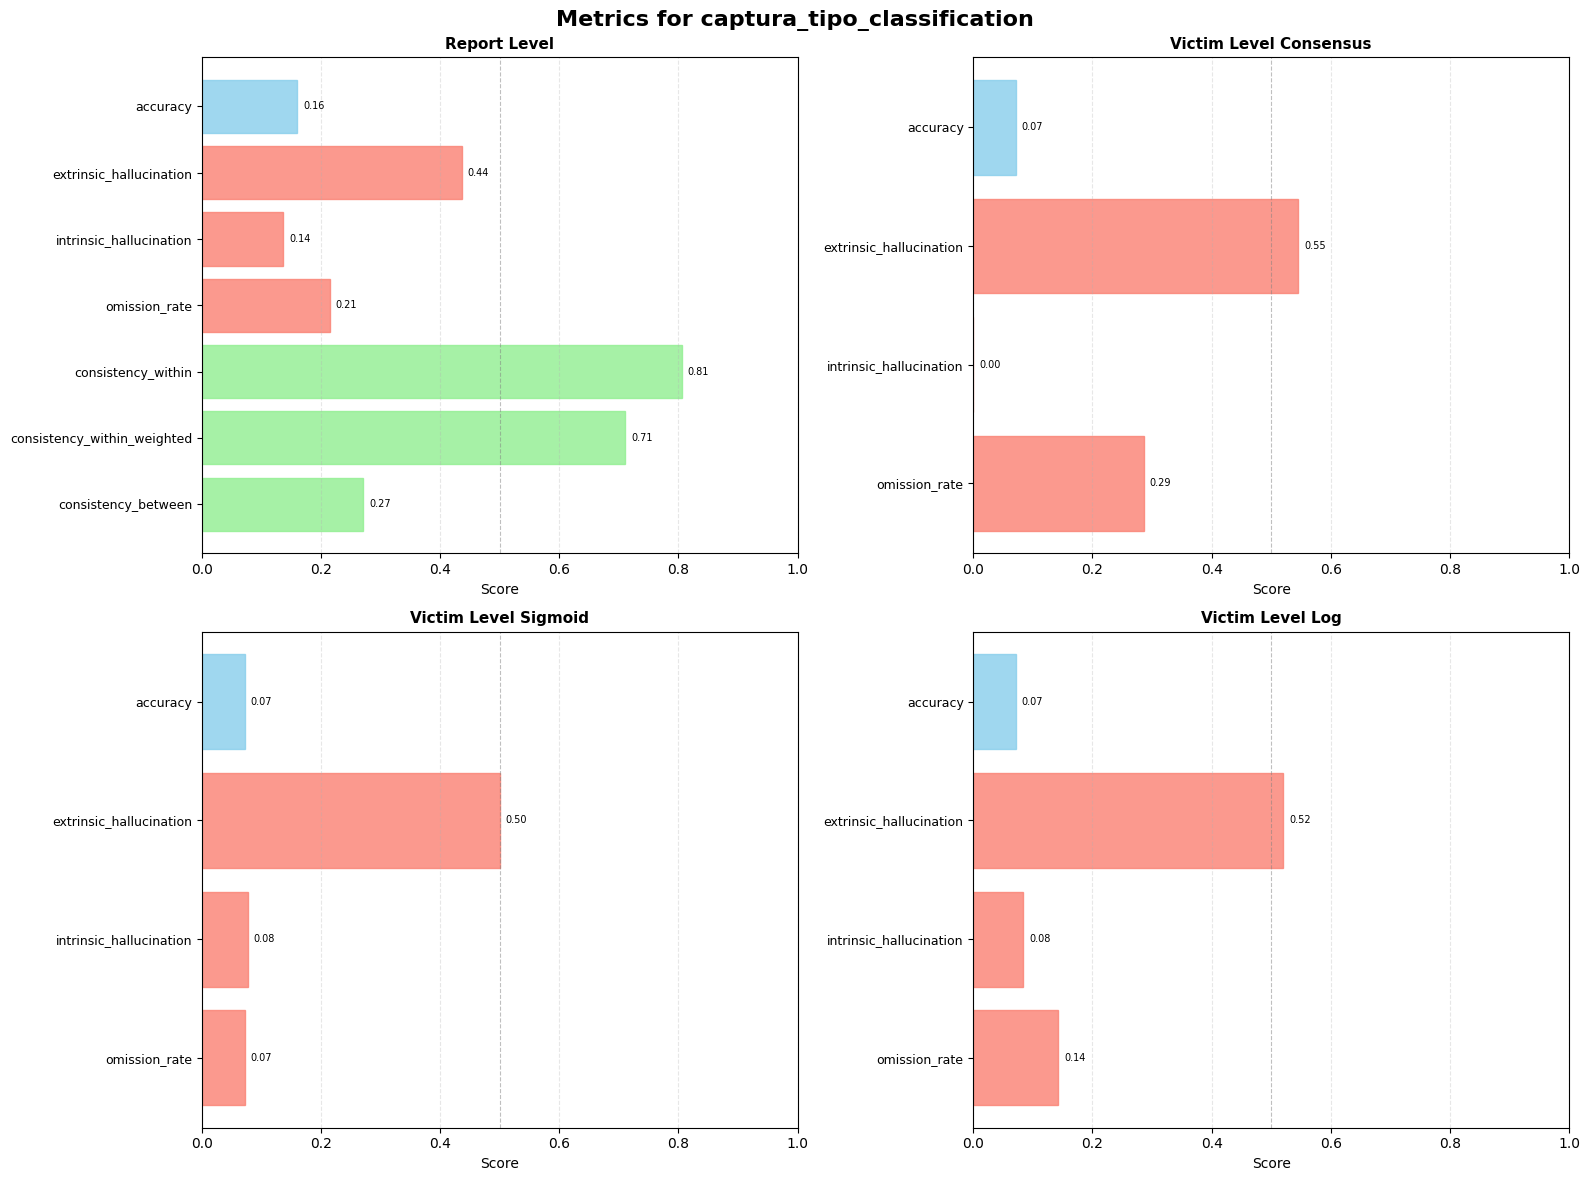

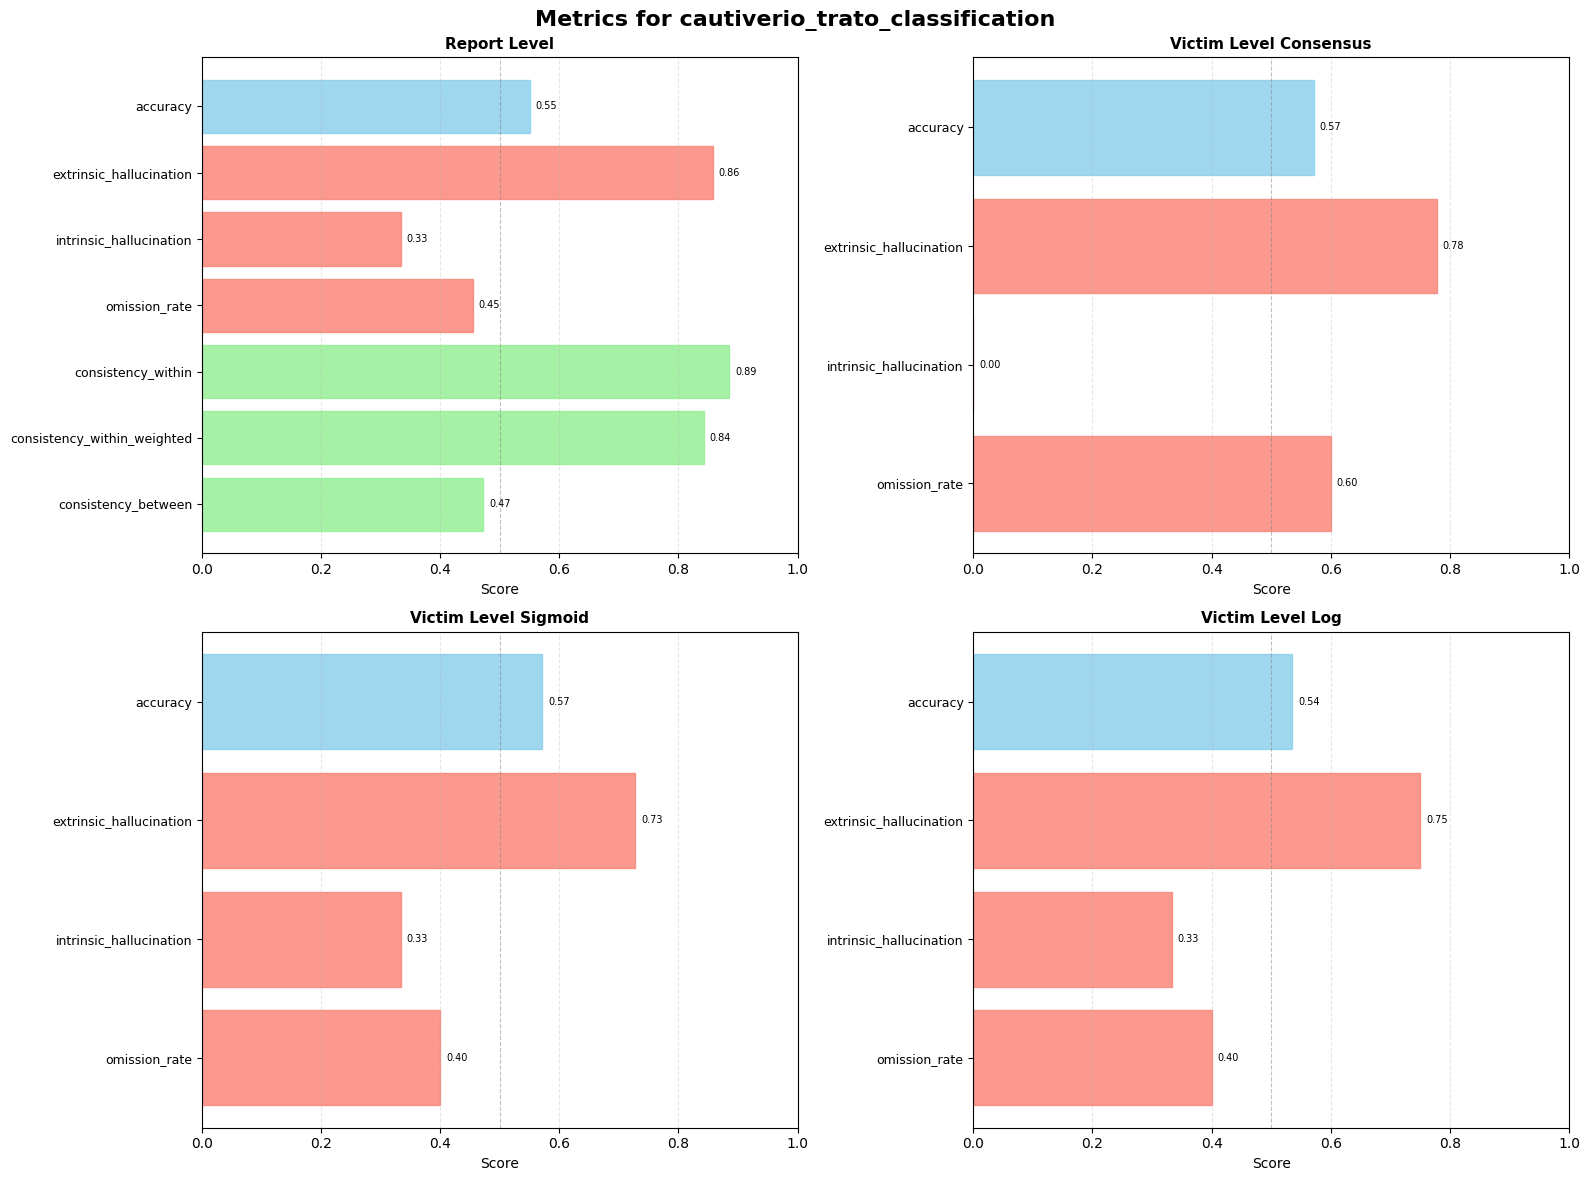

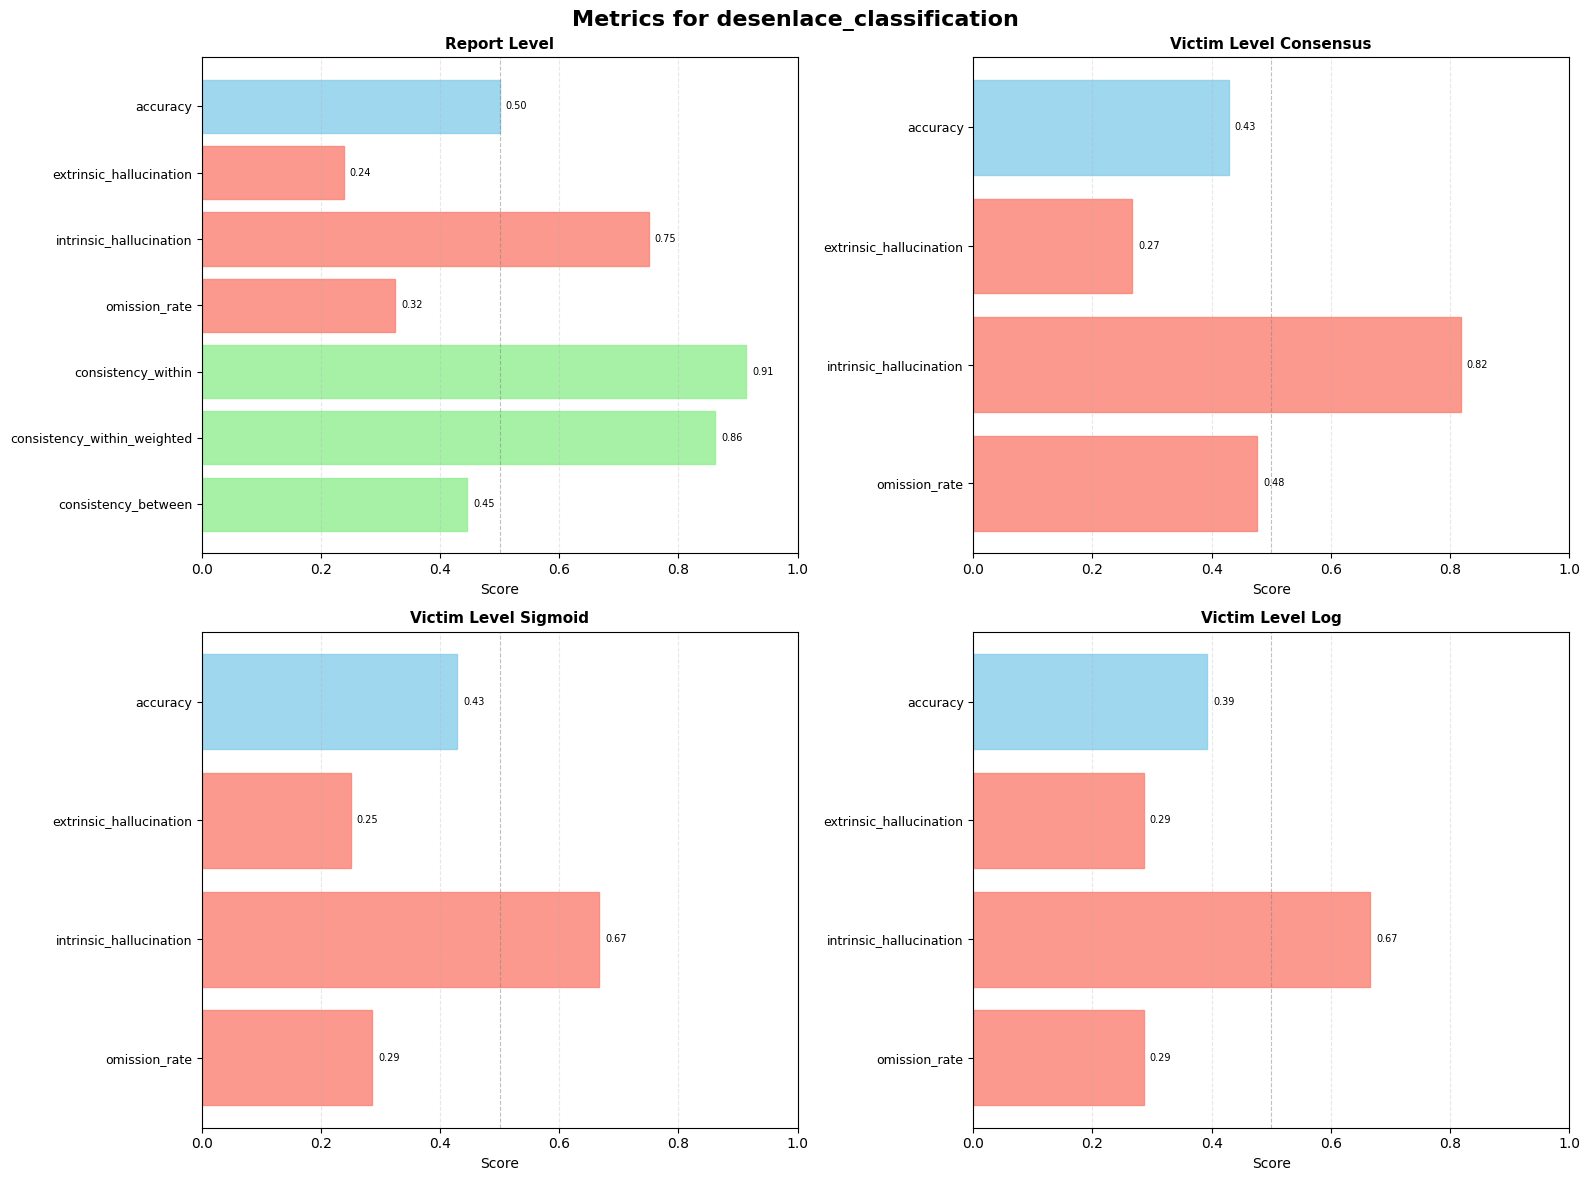

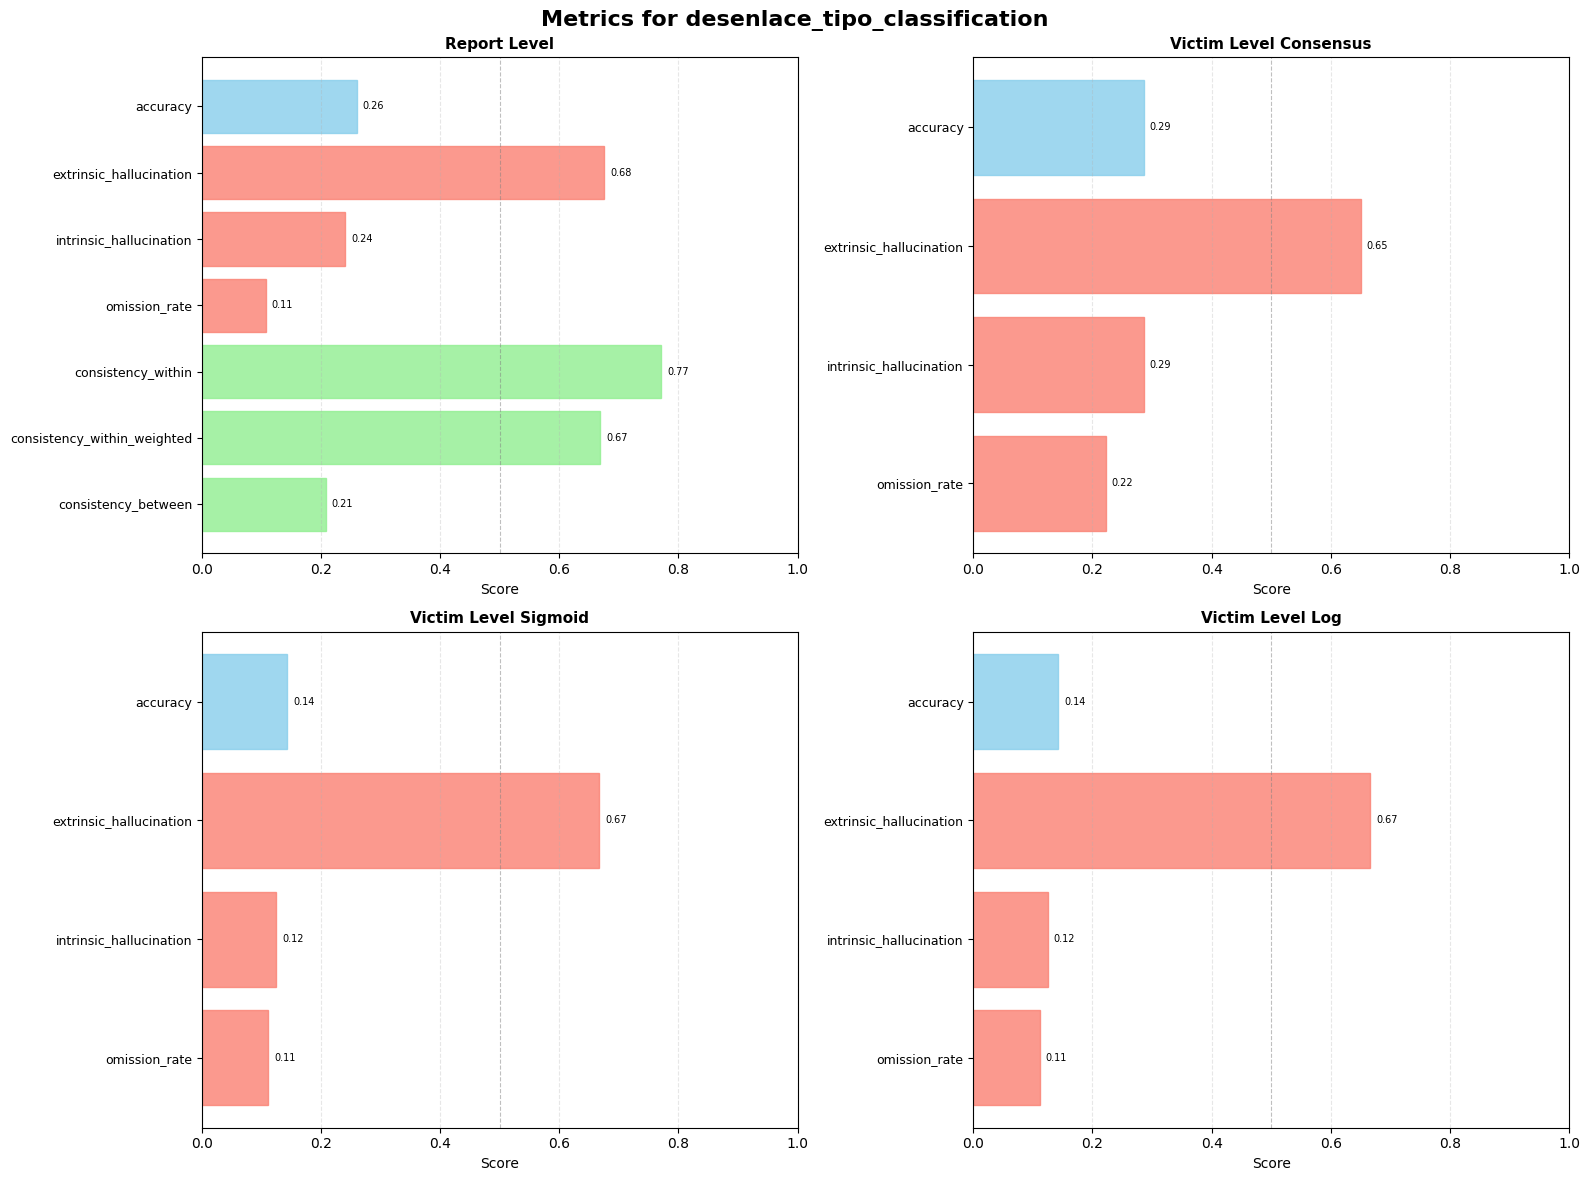

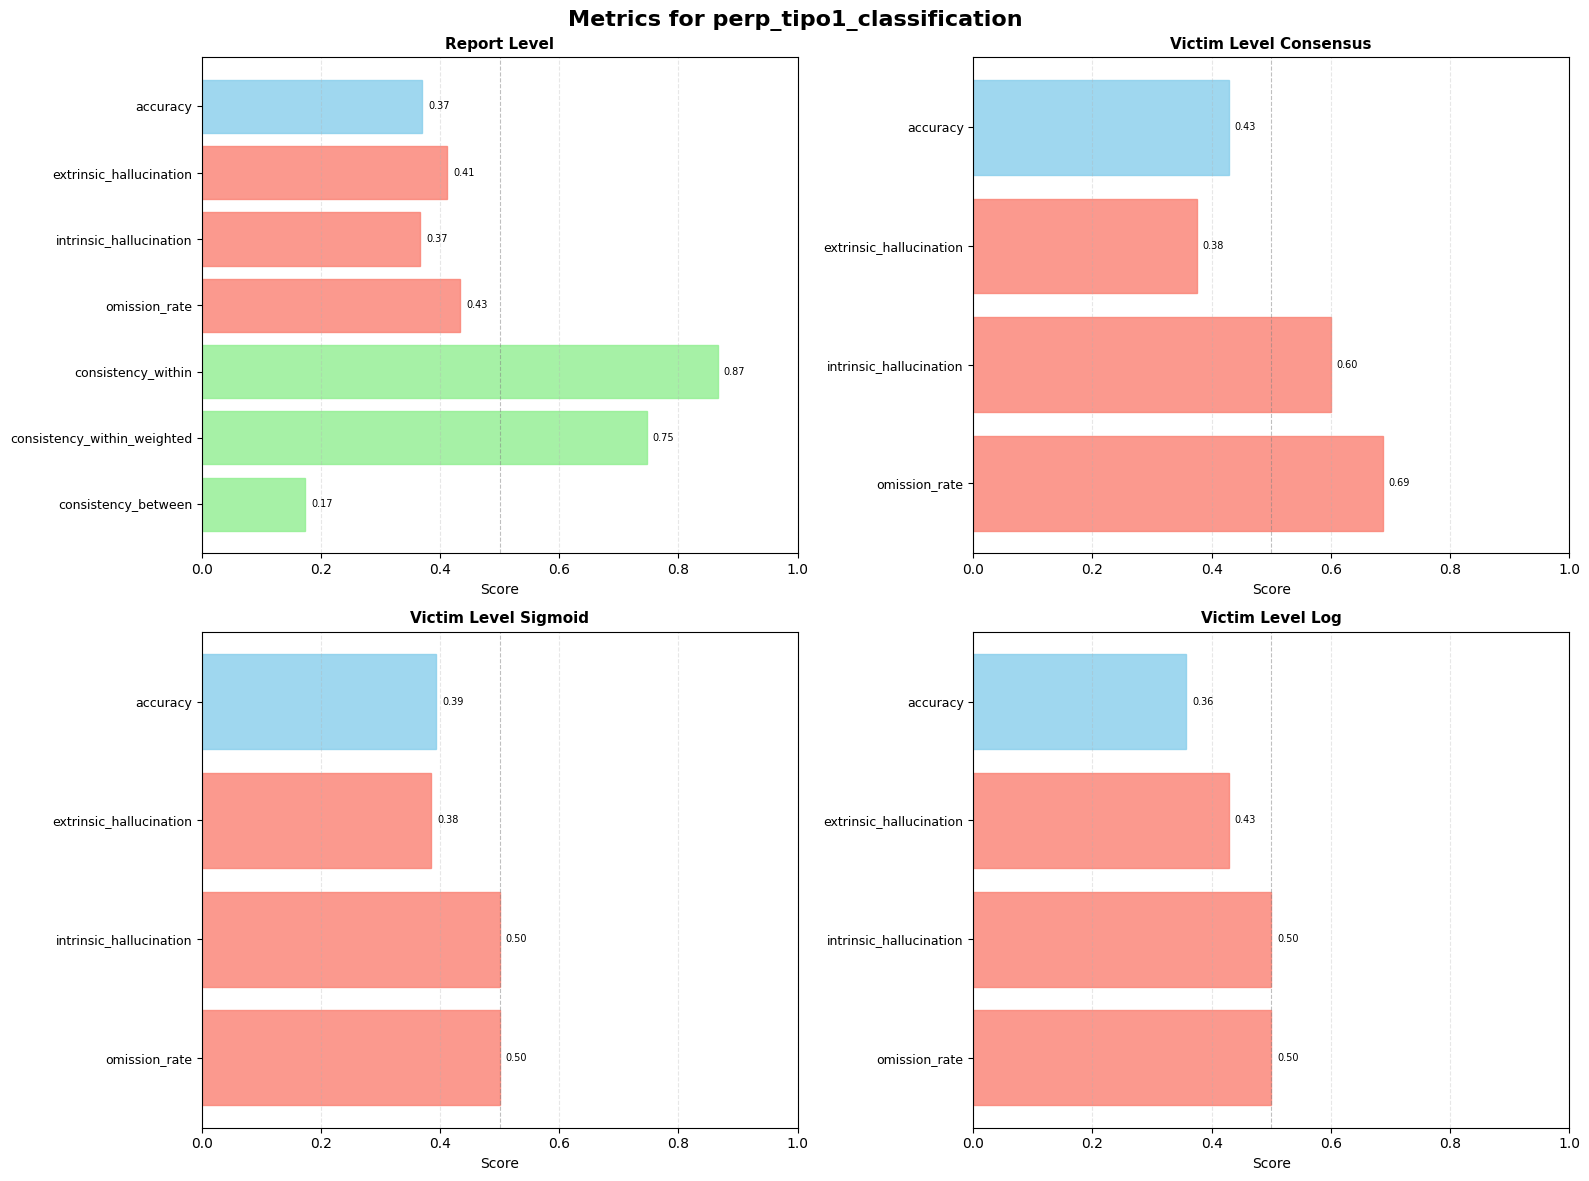

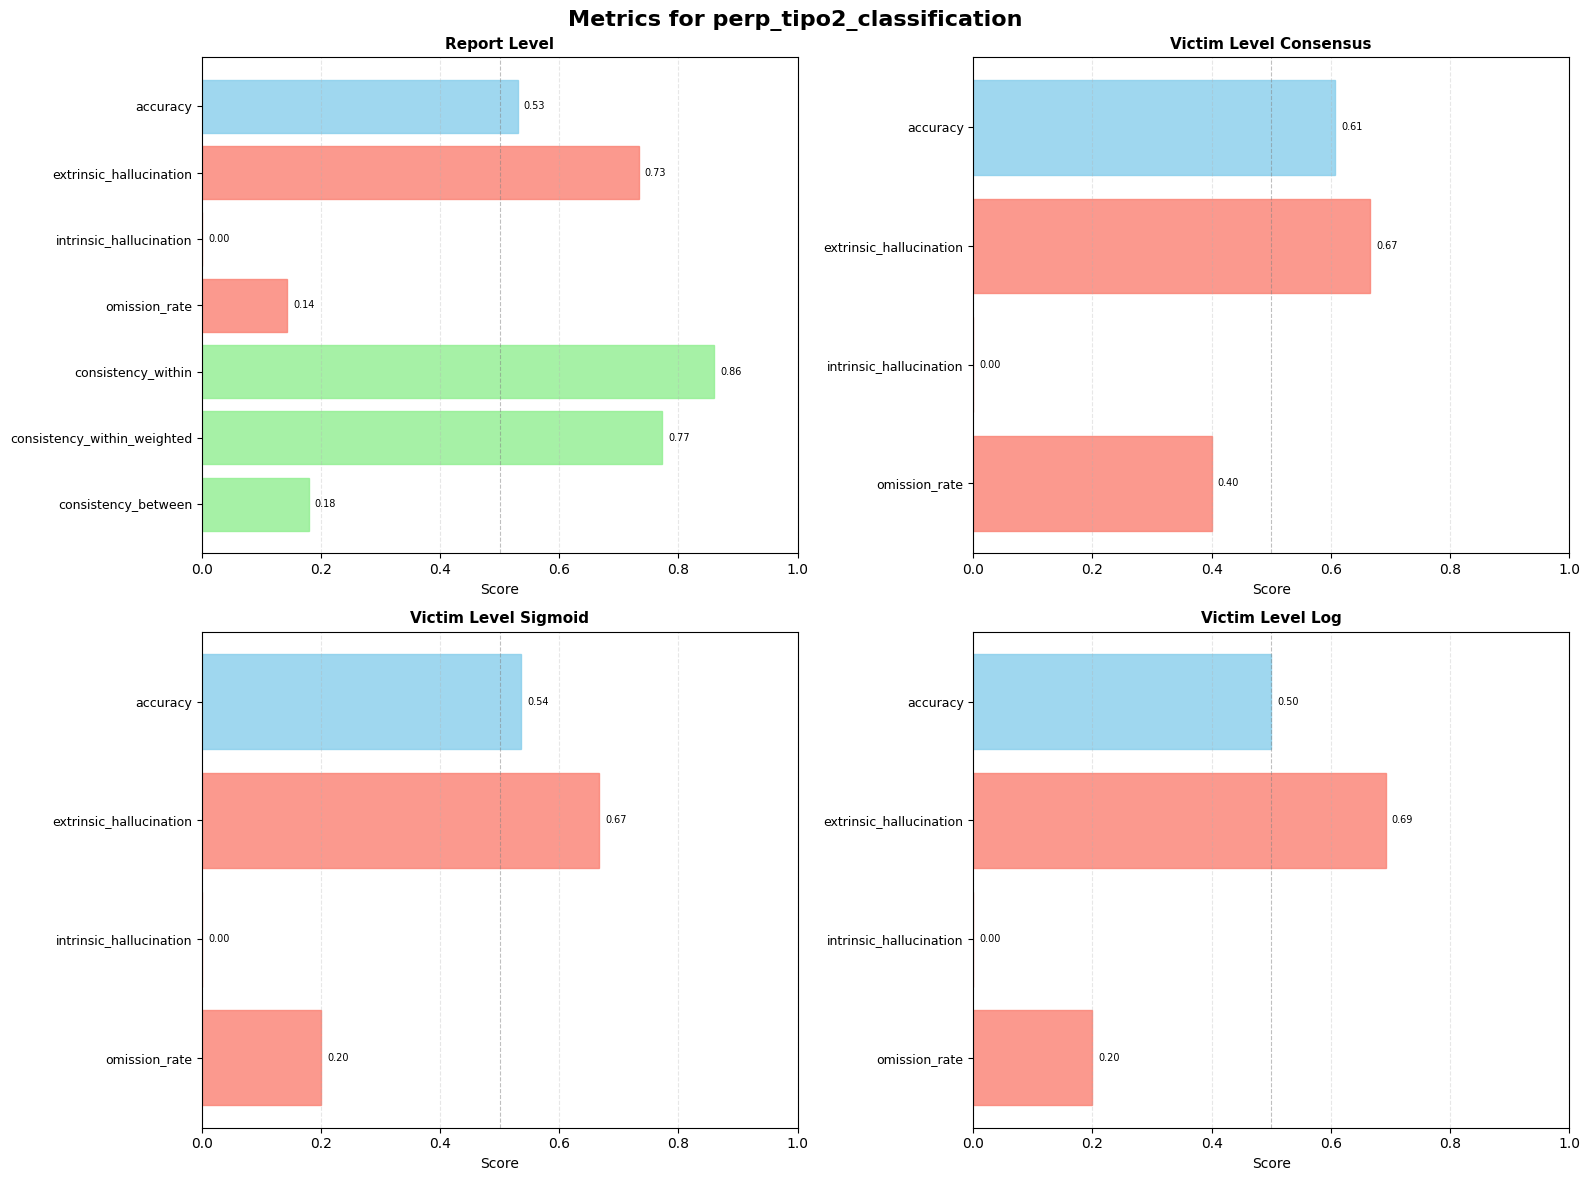

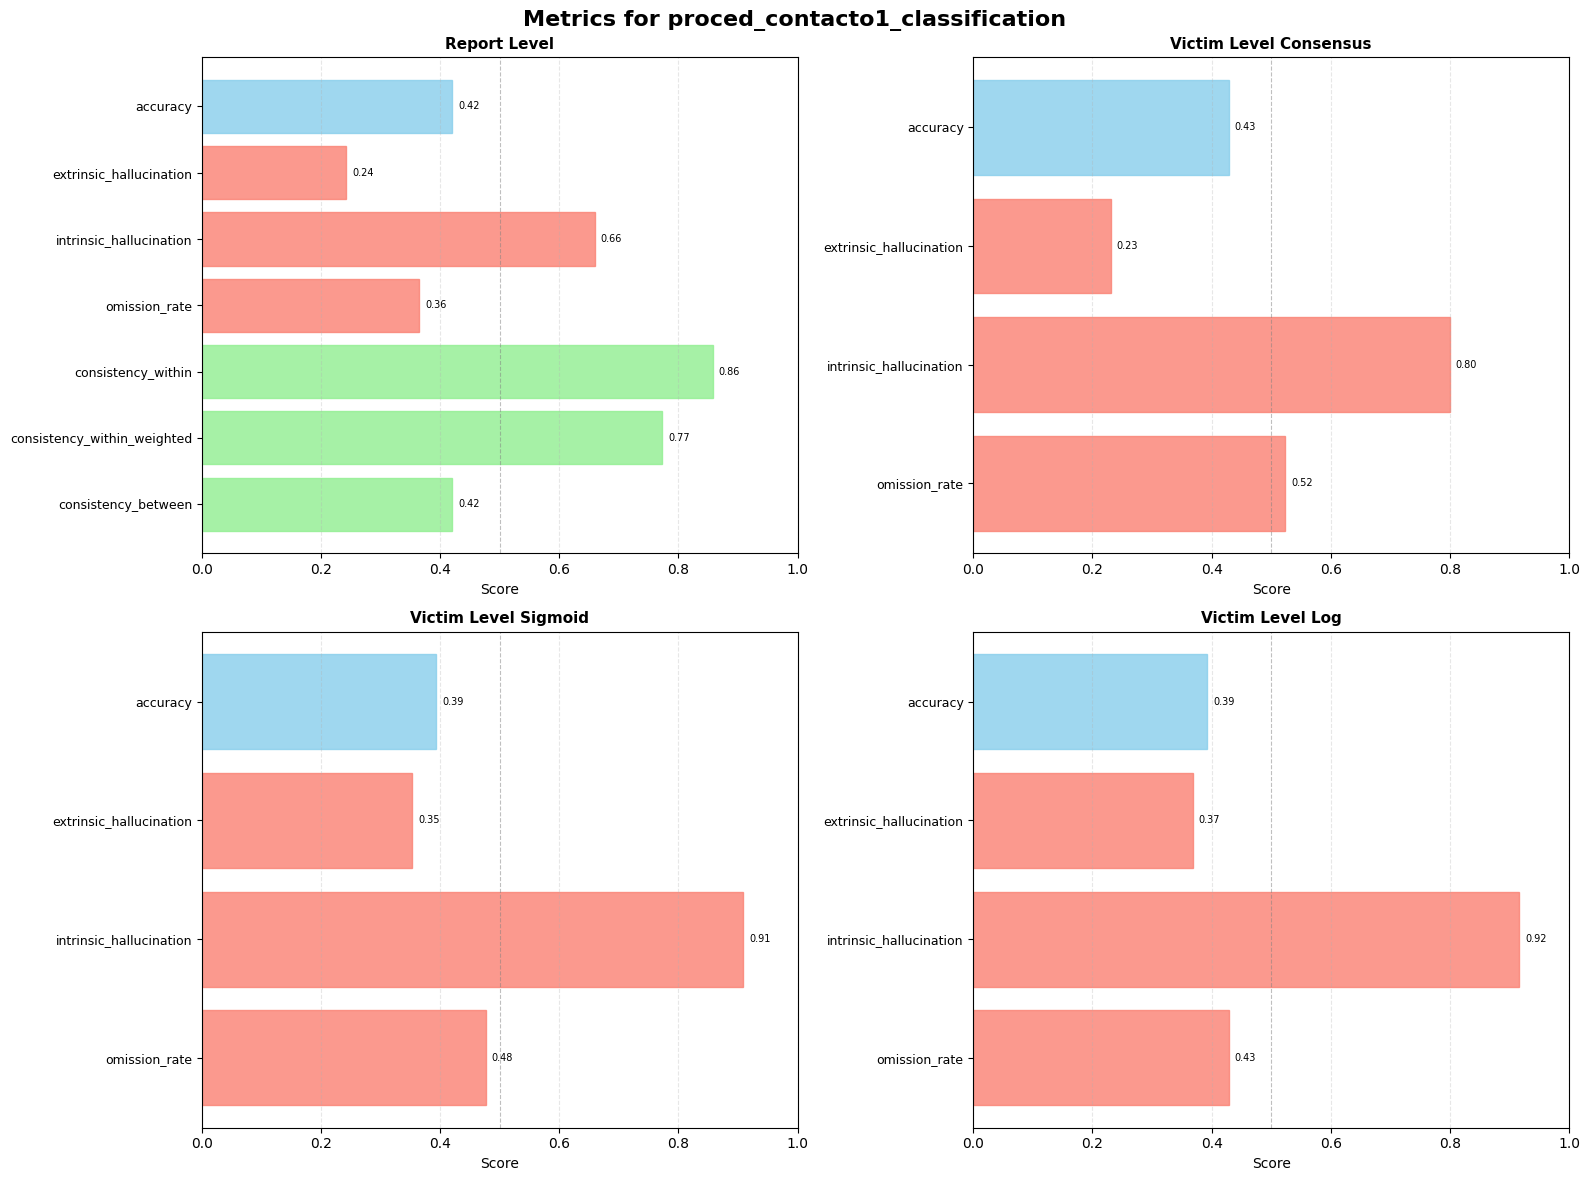

In [ ]:


# Create plots directory if it doesn't exist
if not os.path.exists('plots'):
    os.makedirs('plots')

# Extract all classification column names (they should be consistent across dataframes)
classification_cols = list(results['report_level'].keys())

# Define the metrics we want to plot in the desired order (bottom to top)
metrics_to_plot = [
    # Consistency metrics (will appear at the bottom of the plot)
    'consistency_between',
    'consistency_within_weighted',
    'consistency_within',
    # Error metrics (will appear in the middle)
    'omission_rate',
    'intrinsic_hallucination',
    'extrinsic_hallucination',
    # Performance metrics (will appear at the top)
    'accuracy'
]


# Define dataframe names in order
df_names = ['report_level', 'victim_level_consensus', 'victim_level_sigmoid', 'victim_level_log']

# Loop through each classification column
for classification_col in classification_cols:
    # Create figure with 4 subplots (2x2 grid)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    title = f'Metrics for {classification_col}'
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Flatten axes for easier iteration
    axes_flat = axes.flatten()
    
    # Loop through each dataframe level
    for idx, df_name in enumerate(df_names):
        ax = axes_flat[idx]
        
        # Check if this classification exists in this dataframe
        if classification_col not in results[df_name]:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(df_name.replace('_', ' ').title())
            continue
        
        # Extract metrics for this classification and dataframe
        data = results[df_name][classification_col]
        
        # Collect metric values
        metric_values = []
        metric_labels = []
        
        for metric in metrics_to_plot:
            if metric in ['accuracy', 'precision_macro', 'sensitivity_macro', 
                         'specificity_macro', 'f1_macro', 'cohen_kappa']:
                # These are in the 'metrics' sub-dictionary
                if 'metrics' in data and metric in data['metrics']:
                    value = data['metrics'][metric]
                    if hasattr(value, 'item'): value = value.item()
                    metric_values.append(value)
                    metric_labels.append(metric)
            elif metric in ['consistency_within', 'consistency_within_weighted', 'consistency_between']:
                # These are in the 'consistency' sub-dictionary and only for report_level
                if df_name == 'report_level' and 'consistency' in data and metric in data['consistency']:
                    value = data['consistency'][metric]
                    if hasattr(value, 'item'): value = value.item()
                    metric_values.append(value)
                    metric_labels.append(metric)
            else:
                # These are direct keys
                if metric in data:
                    value = data[metric]
                    if hasattr(value, 'item'): value = value.item()
                    metric_values.append(value)
                    metric_labels.append(metric)
        
        # Create horizontal bar plot
        y_pos = np.arange(len(metric_labels))
        bars = ax.barh(y_pos, metric_values, alpha=0.8, edgecolor='black')
        
        # Color bars based on metric type
        colors = []
        for label in metric_labels:
            if 'hallucination' in label or 'omission' in label:
                colors.append('salmon')  # Red for error metrics (lower is better)
            elif 'consistency' in label:
                colors.append('lightgreen') # Green for consistency
            else:
                colors.append('skyblue')  # Blue for performance metrics (higher is better)
        
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        # Customize subplot
        ax.set_yticks(y_pos)
        ax.set_yticklabels(metric_labels, ha='right', fontsize=9)
        ax.set_xlabel('Score', fontsize=10)
        ax.set_title(df_name.replace('_', ' ').title(), fontsize=11, fontweight='bold')
        ax.set_xlim([0, 1.0])
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
        
        # Add value labels on bars
        for i, (bar, value) in enumerate(zip(bars, metric_values)):
            width = bar.get_width()
            ax.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
                   f'{value:.2f}',
                   ha='left', va='center', fontsize=7)
    
    plt.tight_layout()
    plt.savefig(f'plots/{title}.png')
    plt.show()